## 구내식당_모델링

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder 

## 데이터 로드

In [2]:
train = pd.read_csv('C:/Users/juyeo/Desktop/구내식당/train.csv')
test = pd.read_csv('C:/Users/juyeo/Desktop/구내식당/test.csv')
submission = pd.read_csv('C:/Users/juyeo/Desktop/구내식당/sample_submission.csv')

## 요일 숫자로 매핑

In [3]:
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

## 데이터 전처리 (train)

## 메뉴 임베딩 (중식)

In [4]:
lunch = []
for day in range(len(train)):
    tmp = train.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보는 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    lunch.append(tmp) 
    
np.array(train[ (train.index > 1064) & (train.index < 1069)][['일자', '중식메뉴']])

array([['2020-06-11',
        '쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 매운소고기국  굴비구이  토마토프리타타  도라지오이무침  배추겉절이 (배추국내,고추가루:중국산) '],
       ['2020-06-12',
        '돈육버섯고추장덮밥 (쌀,돈육:국내산) 팽이무국  양파링카레튀김  모듬어묵볶음  참나물생채 요구르트 포기김치 (김치:국내산) '],
       ['2020-07-01',
        '쌀밥/잡곡밥 냉모밀국수 매운돈갈비찜 메밀전병*간장 고구마순볶음 포기김치 양상추샐러드*딸기요거트 '],
       ['2020-07-02',
        '쌀밥/잡곡밥 대파육개장 홍어미나리초무침 어묵잡채 콩자반 배추겉절이 양상추샐러드*오리엔탈 ']],
      dtype=object)

In [5]:
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; kimchi = []; side = []
for i, day_menu in enumerate(lunch):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)

    if i < 1067:
        kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
        side_tmp = day_menu[-2]; side.append(side_tmp)
    else: 
        kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
        side_tmp  = day_menu[-1]; side.append(side_tmp)

In [6]:
train_ln = train[['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식메뉴', '중식계']]
train_ln['bob'] = bob
train_ln['gook'] = gook
train_ln['banchan1'] = banchan1; train_ln['banchan2'] = banchan2; train_ln['banchan3'] = banchan3
train_ln['kimchi'] = kimchi 
train_ln['side'] = side

<ipython-input-6-25f25d13860a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ln['bob'] = bob
<ipython-input-6-25f25d13860a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ln['gook'] = gook


In [7]:
train_ln

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,중식계,bob,gook,banchan1,banchan2,banchan3,kimchi,side
0,2016-02-01,0,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...",1039.0,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,포기김치,요구르트
1,2016-02-02,1,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...",867.0,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,배추겉절이,요구르트
2,2016-02-03,2,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...",1017.0,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,포기김치,요구르트
3,2016-02-04,3,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...",978.0,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,포기김치,요구르트
4,2016-02-05,4,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...",925.0,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,포기김치,요구르트
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,2,2983,75,198,4,391.0,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,1093.0,쌀밥/흑미밥/찰현미밥,아욱국,수제함박스테이크,견과류마카로니범벅,생깻잎지,단호박물김치,양상추샐러드*오리엔탈D
1201,2021-01-21,3,2983,92,231,462,351.0,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,832.0,쌀밥/수수밥/찰현미밥,냉이된장국,동파육,봄동전,청경채/버섯숙회*초장,무생채,양상추샐러드*파인D
1202,2021-01-22,4,2983,255,248,1,303.0,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,579.0,전주비빔밥*약고추장,계란파국,요거닭,올방개묵무침,파프리카해초무침,포기김치,양상추샐러드*자몽D
1203,2021-01-25,0,2983,107,153,616,327.0,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,1145.0,쌀밥/흑미밥/찰현미밥,전주식콩나물해장국,돈육간장불고기,깐풍연근,연두부*달래양념장,봄동겉절이/양념김,양상추샐러드*오렌지D


In [44]:
train_ln['bob'].groupby(['bob']).count()

KeyError: 'bob'

In [34]:
train_ln['bob'].count().sum()

1205

## 메뉴 인베딩 석식

In [8]:
dinner = []
for day in range(len(train)):
    tmp = train.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보는 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    dinner.append(tmp) 
    
np.array(train[ (train.index > 1064) & (train.index < 1069)][['일자', '석식메뉴']])

array([['2020-06-11',
        '야채볶음밥 (쌀:국내산) 초계국수 (닭:국내산) 코코넛새우튀김  옥수수콘치즈  음료  포기김치 (배추국내,고추가루:중국산) '],
       ['2020-06-12',
        '쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 부대찌개 (양지:호주산) 떡갈비조림  쫄면무침  무나물들깨볶음  포기김치 (배추국내,고추가루:중국산) '],
       ['2020-07-01', '쌀밥/잡곡밥 돈육김치찌개 깐풍기 고갈비구이 가지된장무침 포기김치 '],
       ['2020-07-02', '김밥 미니우동 구슬떡볶이 김말이,고추튀김 다시마채무초무침 포기김치 ']],
      dtype=object)

In [9]:
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; kimchi = []; side = []
for i, day_menu in enumerate(dinner):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)

    if i < 1067:
        kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
        side_tmp = day_menu[-2]; side.append(side_tmp)
    else: 
        kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
        side_tmp  = day_menu[-1]; side.append(side_tmp)

In [10]:
train_dn = train[['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '석식메뉴', '석식계']]
train_dn['bob'] = bob
train_dn['gook'] = gook
train_dn['banchan1'] = banchan1; train_dn['banchan2'] = banchan2; train_dn['banchan3'] = banchan3
train_dn['kimchi'] = kimchi 
train_dn['side'] = side

<ipython-input-10-1c928b0492a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dn['bob'] = bob
<ipython-input-10-1c928b0492a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dn['gook'] = gook


## 데이터 전처리 (test)

In [12]:
test

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,2,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,3,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,4,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,0,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,1,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치
5,2021-02-03,2,2924,59,199,5,286.0,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치
6,2021-02-04,3,2924,61,211,476,288.0,모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치
7,2021-02-05,4,2924,169,252,0,256.0,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치
8,2021-02-08,0,2924,88,174,690,329.0,모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치
9,2021-02-09,1,2924,94,183,542,329.0,모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 팥죽/흑미밥 맑은버섯국 시금치나물무침...,쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지


## 메뉴 임베딩 (중식)

In [13]:
lunch_t = []
for day in range(len(test)):
    tmp = test.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보는 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    lunch_t.append(tmp) 
    

In [14]:
bob_t = []; gook_t = []; banchan1_t = []; banchan2_t = []; banchan3_t = []; kimchi_t = []; side_t = []
for i, day_menu in enumerate(lunch_t):
    bob_ttmp = day_menu[0]; bob_t.append(bob_ttmp)
    gook_ttmp = day_menu[1]; gook_t.append(gook_ttmp)
    banchan1_ttmp = day_menu[2]; banchan1_t.append(banchan1_ttmp)
    banchan2_ttmp = day_menu[3]; banchan2_t.append(banchan2_ttmp)
    banchan3_ttmp = day_menu[4]; banchan3_t.append(banchan3_ttmp)
    kimchi_ttmp = day_menu[-2]; kimchi_t.append(kimchi_ttmp)
    side_ttmp = day_menu[-1]; side_t.append(side_ttmp)


In [15]:
test_ln = test[['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식메뉴']]
test_ln['bob'] = bob_t
test_ln['gook'] = gook_t
test_ln['banchan1'] = banchan1_t; test_ln['banchan2'] = banchan2_t; test_ln['banchan3'] = banchan3_t
test_ln['kimchi'] = kimchi_t
test_ln['side'] = side_t

<ipython-input-15-41eec62a42d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ln['bob'] = bob_t


In [16]:
test_ln

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,bob,gook,banchan1,banchan2,banchan3,kimchi,side
0,2021-01-27,2,2983,88,182,5,358.0,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,포기김치,양상추샐러드*딸기D
1,2021-01-28,3,2983,104,212,409,348.0,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,겉절이김치,양상추샐러드*오미자D
2,2021-01-29,4,2983,270,249,0,294.0,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,포기김치,양상추샐러드*파인요거트D
3,2021-02-01,0,2924,108,154,538,322.0,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,포기김치,양상추샐러드*망고D
4,2021-02-02,1,2924,62,186,455,314.0,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,알타리김치/사과푸딩,양상추샐러드*오리엔탈D
5,2021-02-03,2,2924,59,199,5,286.0,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,쌀밥/흑미밥/찰현미밥,아욱국,매콤해물볶음,감자조림,미나리나물,포기김치,콥샐러드*렌치D
6,2021-02-04,3,2924,61,211,476,288.0,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,쌀밥/차조밥/찰현미밥,설렁탕,고등어김치말이찜,볼어묵굴소스볶음,브로콜리숙회*초장,석박지,양상추샐러드*키위D
7,2021-02-05,4,2924,169,252,0,256.0,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,쌀밥/흑미밥/찰현미밥,북엇국,닭볶음탕,채소전*장,솎음열무나물무침,포기김치,양상추샐러드*황도D
8,2021-02-08,0,2924,88,174,690,329.0,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,쌀밥/흑미밥/찰현미밥,감자양파국,돈수육*씨앗쌈장,매콤어묵볶음,콩나물파채무침,포기김치,양상추샐러드*자몽D
9,2021-02-09,1,2924,94,183,542,329.0,쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...,쌀밥/기장밥/찰현미밥,장각백숙,적어양념장구이,채소스틱*쌈장,도라지오이초무침,겉절이김치,양상추샐러드*참깨D


## 메뉴 인베딩 (석식)

In [17]:
dinner_t = []
for day in range(len(test)):
    tmp = test.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보는 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    dinner_t.append(tmp) 
    

In [18]:
bob_t = []; gook_t = []; banchan1_t = []; banchan2_t = []; banchan3_t = []; kimchi_t = []; side_t = []
for i, day_menu in enumerate(dinner_t):
    bob_ttmp = day_menu[0]; bob_t.append(bob_ttmp)
    gook_ttmp = day_menu[1]; gook_t.append(gook_ttmp)
    banchan1_ttmp = day_menu[2]; banchan1_t.append(banchan1_ttmp)
    banchan2_ttmp = day_menu[3]; banchan2_t.append(banchan2_ttmp)
    banchan3_ttmp = day_menu[4]; banchan3_t.append(banchan3_ttmp)
    kimchi_ttmp = day_menu[-2]; kimchi_t.append(kimchi_ttmp)
    side_ttmp = day_menu[-1]; side_t.append(side_ttmp)


In [19]:
test_dn = test[['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '석식메뉴']]
test_dn['bob'] = bob_t
test_dn['gook'] = gook_t
test_dn['banchan1'] = banchan1_t; test_dn['banchan2'] = banchan2_t; test_dn['banchan3'] = banchan3_t
test_dn['kimchi'] = kimchi_t
test_dn['side'] = side_t

<ipython-input-19-2bb9da5aa32a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dn['bob'] = bob_t


In [20]:
test_dn

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,석식메뉴,bob,gook,banchan1,banchan2,banchan3,kimchi,side
0,2021-01-27,2,2983,88,182,5,358.0,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,포기김치,양상추샐러드*딸기D
1,2021-01-28,3,2983,104,212,409,348.0,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,겉절이김치,양상추샐러드*오미자D
2,2021-01-29,4,2983,270,249,0,294.0,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,포기김치,양상추샐러드*파인요거트D
3,2021-02-01,0,2924,108,154,538,322.0,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,포기김치,양상추샐러드*망고D
4,2021-02-02,1,2924,62,186,455,314.0,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,알타리김치/사과푸딩,양상추샐러드*오리엔탈D
5,2021-02-03,2,2924,59,199,5,286.0,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치,쌀밥/흑미밥/찰현미밥,아욱국,매콤해물볶음,감자조림,미나리나물,포기김치,콥샐러드*렌치D
6,2021-02-04,3,2924,61,211,476,288.0,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치,쌀밥/차조밥/찰현미밥,설렁탕,고등어김치말이찜,볼어묵굴소스볶음,브로콜리숙회*초장,석박지,양상추샐러드*키위D
7,2021-02-05,4,2924,169,252,0,256.0,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,쌀밥/흑미밥/찰현미밥,북엇국,닭볶음탕,채소전*장,솎음열무나물무침,포기김치,양상추샐러드*황도D
8,2021-02-08,0,2924,88,174,690,329.0,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치,쌀밥/흑미밥/찰현미밥,감자양파국,돈수육*씨앗쌈장,매콤어묵볶음,콩나물파채무침,포기김치,양상추샐러드*자몽D
9,2021-02-09,1,2924,94,183,542,329.0,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지,쌀밥/기장밥/찰현미밥,장각백숙,적어양념장구이,채소스틱*쌈장,도라지오이초무침,겉절이김치,양상추샐러드*참깨D


## 모델링

## 수치 데이터만 선택 (중식)

In [21]:
x_train = train_ln[['요일', '본사정원수','본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test_ln[['요일', '본사정원수','본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [22]:
## 훈련데이터 분리
x1_train, x1_test, x2_train, x2_test = train_test_split(x_train, y1_train, test_size=0.2, random_state=1)

## 랜덤포레스트 (베이스라인)
model1 = RandomForestRegressor(n_jobs=-1, random_state=42, criterion='mae')
model1.fit(x_train, y1_train)
x2_train_pred = model1.predict(x1_train)
x2_test_pred = model1.predict(x1_test)

## 성능 평가 (R-squared 상관계수)
print('훈련 MAE: %.3f, 테스트 MAE: %.3f' %(mean_squared_error(x2_train, x2_train_pred), mean_squared_error(x2_test, x2_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' %(r2_score(x2_train, x2_train_pred), r2_score(x2_test, x2_test_pred)))

훈련 MAE: 1373.070, 테스트 MAE: 1322.088
훈련 R^2: 0.969, 테스트 R^2: 0.970


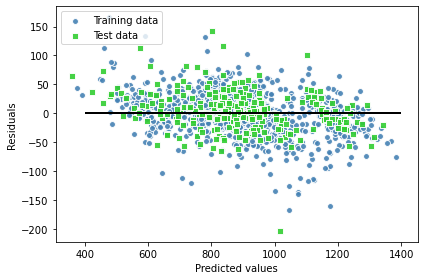

In [23]:
## 잔차그래프
plt.scatter(x2_train_pred, x2_train_pred - x2_train, c='steelblue', edgecolor='white', marker='o', s=35, alpha=0.9, label='Training data')
plt.scatter(x2_test_pred, x2_test_pred - x2_test, c='limegreen', edgecolor='white', marker='s', s=35, alpha=0.9, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=400, xmax=1400, lw=2, color='black')
plt.tight_layout()
plt.show()

## 수치 데이터만 선택 (석식)

In [24]:
x_train = train_dn[['요일', '본사정원수','본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test_dn[['요일', '본사정원수','본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [25]:
## 훈련데이터 분리
x1_train, x1_test, x2_train, x2_test = train_test_split(x_train, y2_train, test_size=0.2, random_state=1)

## 랜덤포레스트 (베이스라인)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42, criterion='mae')
model2.fit(x_train, y2_train)
x2_train_pred = model2.predict(x1_train)
x2_test_pred = model2.predict(x1_test)

## 성능 평가 (R-squared 상관계수)
print('훈련 MAE: %.3f, 테스트 MAE: %.3f' %(mean_squared_error(x2_train, x2_train_pred), mean_squared_error(x2_test, x2_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' %(r2_score(x2_train, x2_train_pred), r2_score(x2_test, x2_test_pred)))

훈련 MAE: 1475.358, 테스트 MAE: 1261.937
훈련 R^2: 0.923, 테스트 R^2: 0.938


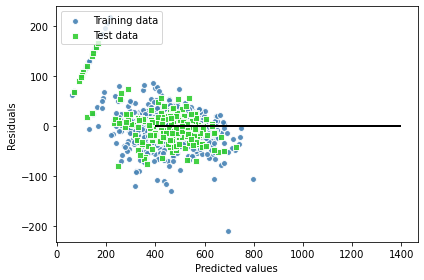

In [26]:
## 잔차그래프
plt.scatter(x2_train_pred, x2_train_pred - x2_train, c='steelblue', edgecolor='white', marker='o', s=35, alpha=0.9, label='Training data')
plt.scatter(x2_test_pred, x2_test_pred - x2_test, c='limegreen', edgecolor='white', marker='s', s=35, alpha=0.9, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=400, xmax=1400, lw=2, color='black')
plt.tight_layout()
plt.show()

## 추론

In [27]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)

In [28]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [29]:
submission.to_csv('baseline.csv', index=False)

In [30]:
submission = pd.read_csv('C:/Users/juyeo/Desktop/구내식당//sample_submission.csv')

In [31]:
submission

,일자,중식계,석식계
0,2021-01-27,1026.570,405.030
1,2021-01-28,972.200,397.480
2,2021-01-29,594.700,268.940
3,2021-02-01,1203.765,485.520
4,2021-02-02,958.410,461.190
5,2021-02-03,1002.170,402.930
6,2021-02-04,924.090,477.400
7,2021-02-05,596.850,341.310
8,2021-02-08,1170.835,646.470
9,2021-02-09,989.570,511.270
